In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!ls "drive/My Drive/Colab Notebooks/data"

GoogleNews-vectors-negative300.bin     news_proc_12_3_19.pickle
GoogleNews-vectors-negative300.bin.gz  vectors.zip


In [30]:
import tensorflow as tf
import tensorflow.keras as k
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Imports, loads , Train/test split and Optimum params
---

In [31]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn-v0_8')
import seaborn as sns

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [32]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

In [33]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

truth - [1]
fake - [0]


In [34]:
# len_content = len(data['content'][0])
len_content = max([len(c) for c in data['content']])
# len_title = len(data['title'][0])
len_title = max([len(c) for c in data['title']])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1590
Max len title: 13


In [ ]:
#!/bin/bash
!curl -L -o "drive/My Drive/Colab Notebooks/data/vectors.zip" https://www.kaggle.com/api/v1/datasets/download/leadbest/googlenewsvectorsnegative300

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3250M  100 3250M    0     0  38.7M      0  0:01:23  0:01:23 --:--:-- 38.2M


In [ ]:
!unzip "drive/My Drive/Colab Notebooks/data/vectors.zip" -d "drive/My Drive/Colab Notebooks/data"

Archive:  drive/My Drive/Colab Notebooks/data/vectors.zip
replace drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin  






  inflating: drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz  


In [35]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin", binary=True, limit=50000)

In [36]:

embed_mat = np.zeros((50000,300))
for i, e in model.key_to_index.items():
    embed_mat[e] = model[i]
pd.DataFrame(embed_mat)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.000420,-0.000576,0.001076,...,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.001160,0.000568,-0.001564,-0.000123,-0.000086
1,0.070312,0.086914,0.087891,0.062500,0.069336,-0.108887,-0.081543,-0.154297,0.020752,0.131836,...,-0.168945,-0.088867,-0.080566,0.064941,0.061279,-0.047363,-0.058838,-0.047607,0.014465,-0.062500
2,-0.011780,-0.047363,0.044678,0.063477,-0.018188,-0.063965,-0.001312,-0.072266,0.064453,0.086426,...,-0.022583,0.003723,-0.082520,0.081543,0.007935,0.000477,0.018433,0.071289,-0.034912,0.024170
3,-0.015747,-0.028320,0.083496,0.050293,-0.110352,0.031738,-0.014221,-0.089844,0.117676,0.118164,...,-0.011292,-0.015625,-0.033447,-0.020630,-0.019409,0.063965,0.020142,0.006866,0.061035,-0.148438
4,0.007050,-0.073242,0.171875,0.022583,-0.132812,0.198242,0.112793,-0.107910,0.071777,0.020874,...,-0.233398,-0.036377,-0.093750,0.182617,0.027100,0.127930,-0.024780,0.011230,0.164062,0.106934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.080078,-0.055420,-0.136719,-0.106445,-0.066895,-0.032227,0.097656,-0.162109,-0.063965,0.001801,...,0.053955,0.024292,-0.269531,0.148438,-0.153320,0.063477,-0.212891,-0.277344,-0.059326,-0.114258
49996,-0.233398,-0.656250,0.041016,0.021362,0.145508,-0.247070,1.289062,-0.251953,0.367188,-0.037598,...,-0.339844,0.636719,-0.972656,1.000000,0.215820,0.359375,0.359375,-0.917969,1.101562,0.417969
49997,-0.013733,0.244141,-0.124512,-0.031250,0.191406,-0.259766,0.261719,0.287109,0.014038,0.038574,...,0.113770,-0.106445,-0.320312,-0.136719,0.251953,0.015991,0.184570,-0.241211,0.153320,0.043945
49998,0.277344,0.036377,0.061768,0.197266,-0.102539,-0.020142,0.020142,-0.109863,-0.012817,-0.007172,...,0.027588,0.105957,-0.012024,0.034668,-0.137695,-0.115234,-0.041992,-0.102539,-0.062256,0.126953


### Train/valid/test split

In [37]:
print(data)

         type                                            content  \
0       truth  [51, 4, 903, 387, 2087, 8, 21619, 9248, 5, 28,...   
1       truth  [232, 71, 603, 4384, 3445, 1346, 911, 1144, 11...   
2       truth  [62, 1364, 1082, 738, 46, 5320, 10034, 166, 25...   
3       truth  [7, 637, 11, 16301, 1828, 92, 13, 216, 1831, 1...   
4       truth  [5124, 538, 4, 7683, 41, 46, 2034, 3770, 9252,...   
...       ...                                                ...   
117560   fake  [169, 85, 15, 7687, 1244, 11, 1262, 640, 12654...   
117561   fake  [7196, 17, 9571, 7538, 430, 11134, 11, 1609, 3...   
117562   fake  [1732, 4, 85, 706, 2, 11, 5218, 540, 58, 41890...   
117563   fake  [17041, 17391, 97, 1954, 46781, 1867, 3512, 31...   
117564   fake  [7196, 4532, 3755, 5597, 1190, 21656, 591, 198...   

                                                    title one_hot_label  
0       [13763, 3374, 1, 11, 17389, 531, 21619, 9923, ...           [1]  
1       [1674, 1037, 38, 141, 9923,

In [38]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [39]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [55]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assume len_title and len_content are the maximum sequence lengths
# you want to use for padding
train_fit = {
    'title_input': pad_sequences(X_train_title, maxlen=len_title, padding='post'),
    'content_input': pad_sequences(X_train_content, maxlen=len_content, padding='post')
}

valid_fit = {
    'title_input': pad_sequences(X_valid_title, maxlen=len_title, padding='post'),
    'content_input': pad_sequences(X_valid_content, maxlen=len_content, padding='post')
}

test_fit = {
    'title_input': pad_sequences(X_test_title, maxlen=len_title, padding='post'),
    'content_input': pad_sequences(X_test_content, maxlen=len_content, padding='post')
}


In [ ]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

In [48]:
type(train_fit)

list

## Optimum Params found with Bayesian Optimization

In [41]:
params_lstm = {
    'lr': 0.23097138708141426,
    'momentum': 0.001,
    'dropout': 0.14630023637797968,
    'dense1': 59,
    'dense2': 31,
    'lstmTitle': 79,
    'lstmContent': 157
}


In [67]:
def create_model(len_title, len_content, embed_mat, params_lstm):
    # Input for title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(
        output_dim=300,
        input_dim=50000,
        weights=[embed_mat],
        trainable=False
    )(title_input)

    # Use CuDNNLSTM (now CuDNNCompatible in TF 2.x)
    x = k.layers.Bidirectional(
        k.layers.LSTM(params_lstm['lstmTitle'], return_sequences=False)
    )(inp)

    # Input for content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(
        output_dim=300,
        input_dim=50000,
        weights=[embed_mat],
        trainable=False
    )(content_input)

    # Use CuDNNLSTM (now CuDNNCompatible in TF 2.x)
    x2 = k.layers.Bidirectional(
        k.layers.LSTM(params_lstm['lstmContent'], return_sequences=False)
    )(inp2)

    # Merge layers
    x = k.layers.concatenate([x, x2])

    # Common dense layers
    x = k.layers.Dense(params_lstm['dense1'], activation='relu')(x)
    x = k.layers.Dropout(params_lstm['dropout'])(x)
    x = k.layers.Dense(params_lstm['dense2'], activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)

    # Output layer
    out = k.layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    # Compile model using Adam optimizer (recommended in TF 2.x)
    model.compile(
        optimizer=k.optimizers.SGD(learning_rate=params_lstm['lr'], momentum=params_lstm['momentum']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [68]:
# Example usage
model = create_model(len_title, len_content, embed_mat, params_lstm)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)  │ (None, 13)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ content_input             │ (None, 1590)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 13, 300)        │     15,000,000 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1590, 300)      │     15,000,000 │ content_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 158)            │        240,160 │ embedding_6[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 314)            │        575,248 │ embedding_7[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 472)            │              0 │ bidirectional_6[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 59)             │         27,907 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 59)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 31)             │          1,860 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 31)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             32 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,845,207 (117.67 MB)

 Trainable params: 845,207 (3.22 MB)

 Non-trainable params: 30,000,000 (114.44 MB)

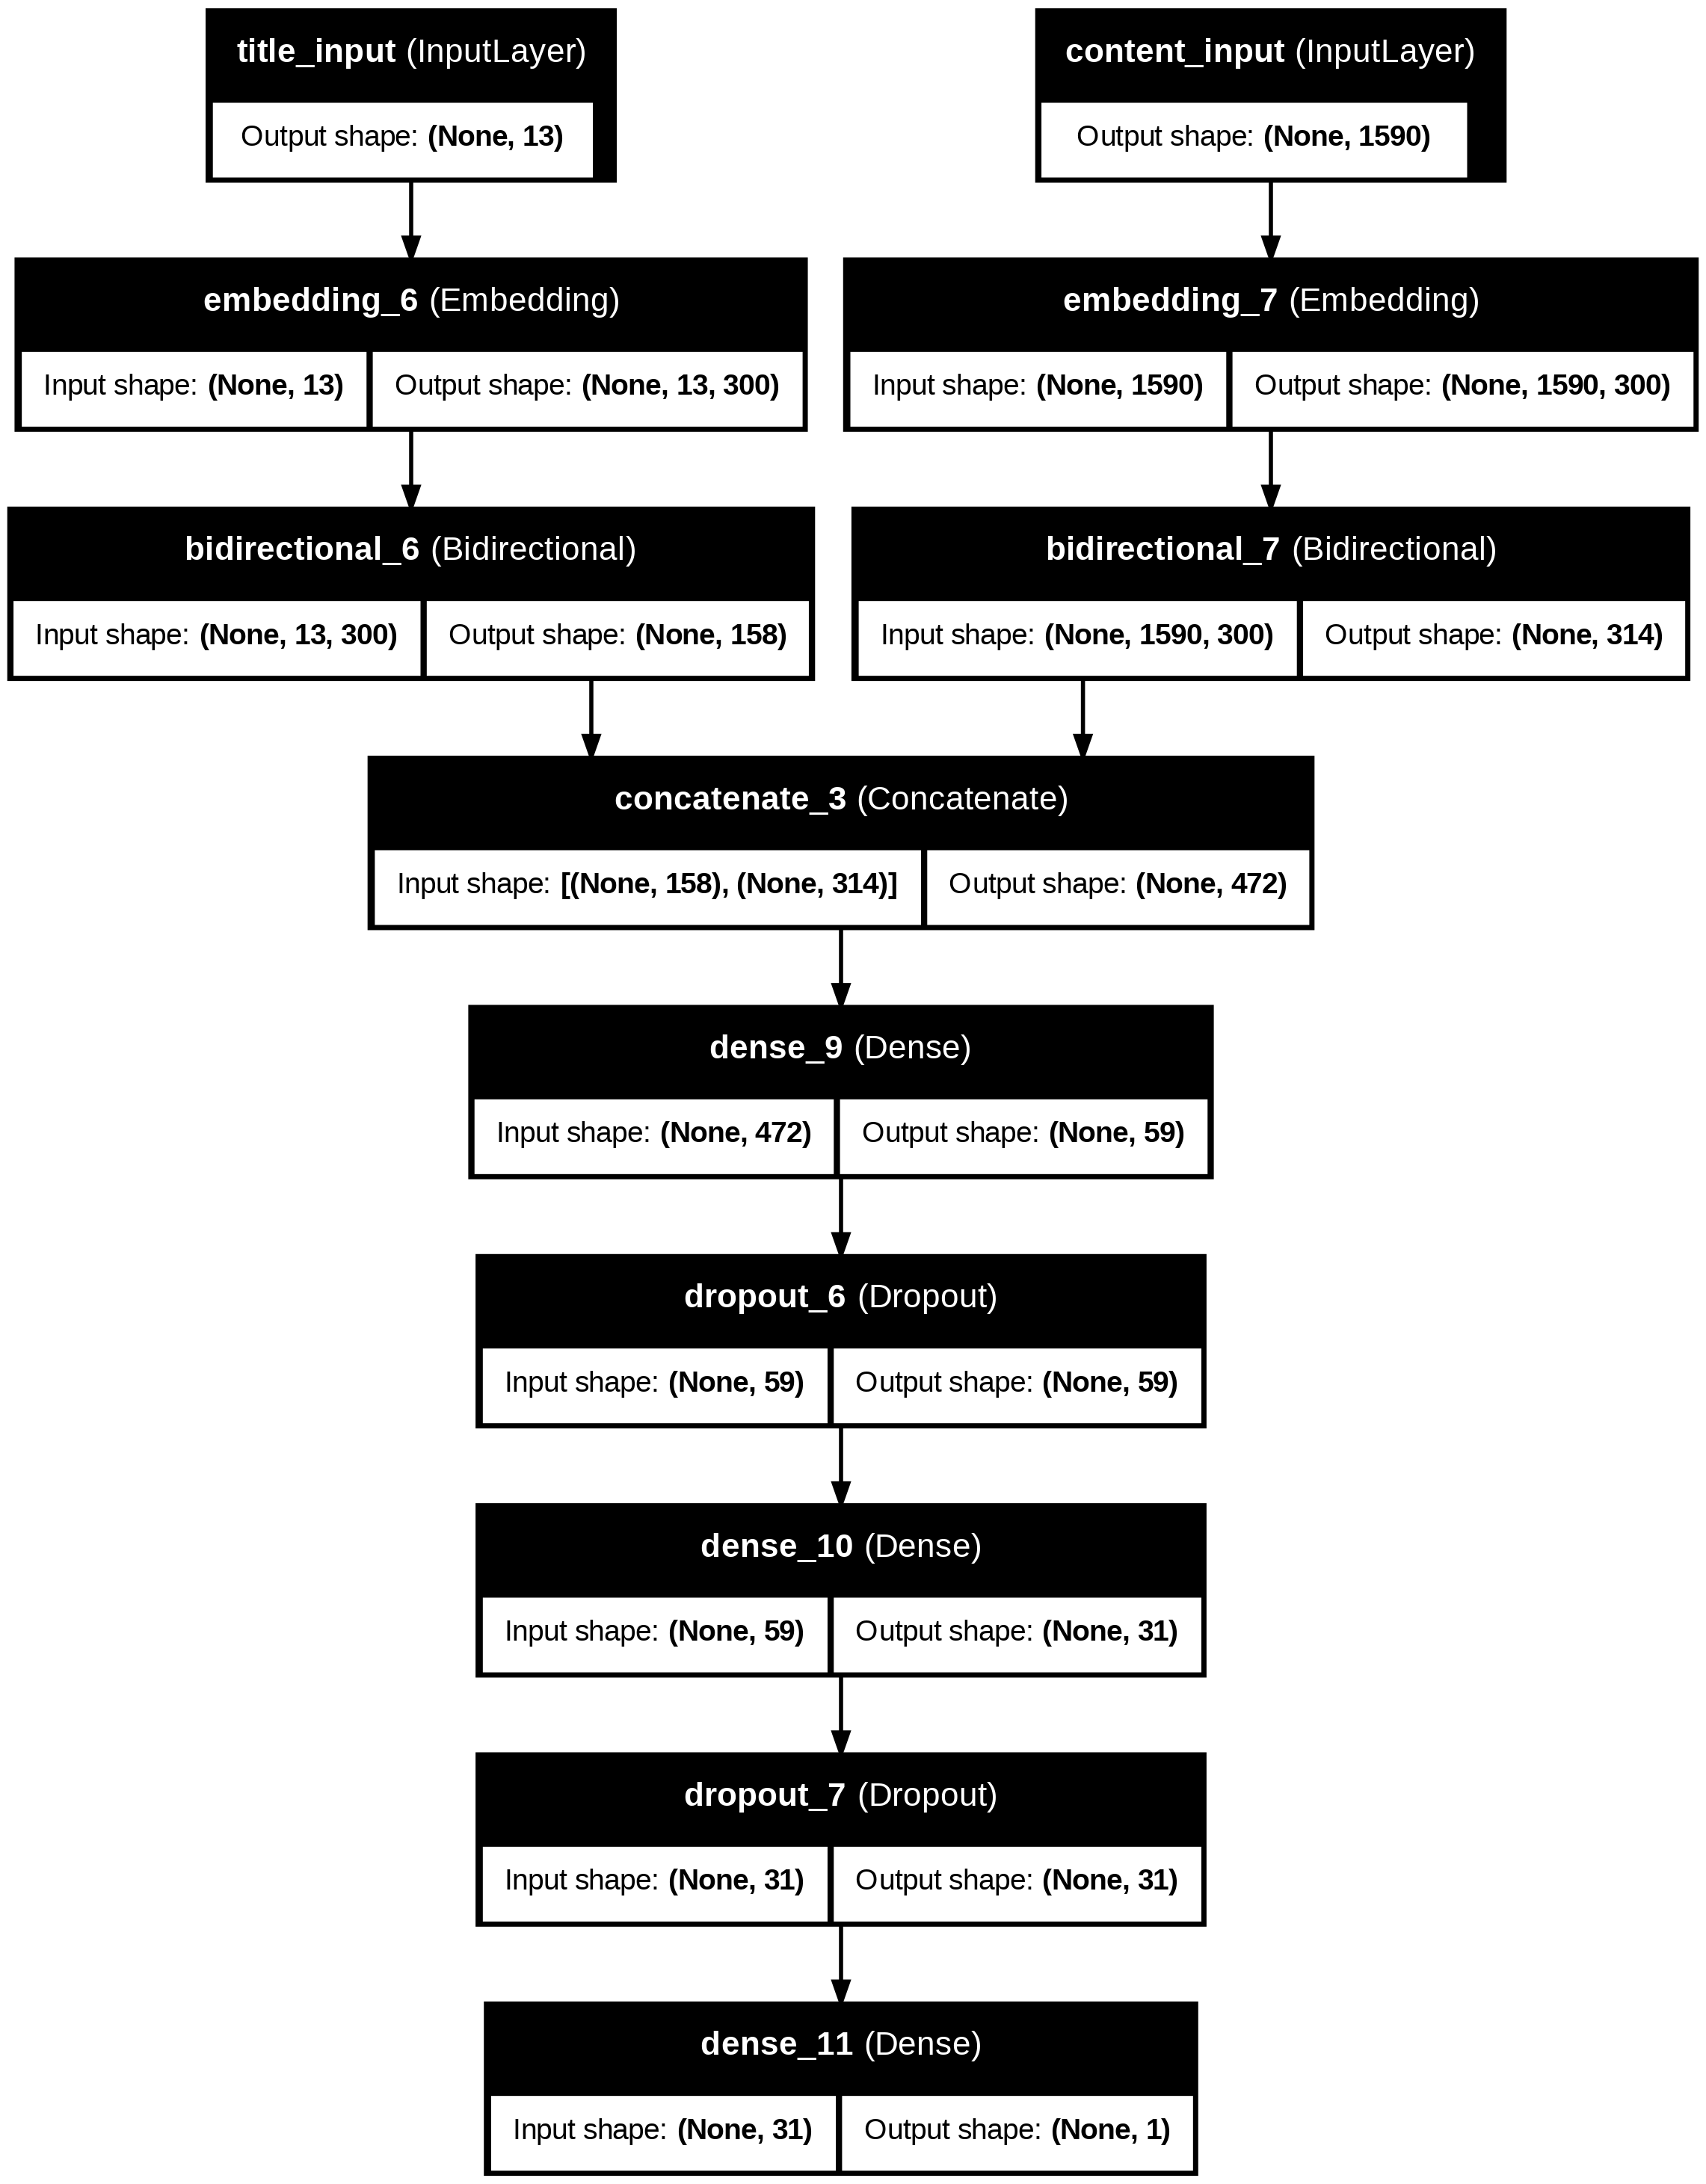

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [70]:
hist = model.fit(x=train_fit,y=np.array(y_train.tolist()), batch_size=64*4, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.01,mode='min')],
                 validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 422ms/step - accuracy: 0.8167 - loss: 0.4167 - val_accuracy: 0.9044 - val_loss: 0.2288
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 423ms/step - accuracy: 0.9029 - loss: 0.2194 - val_accuracy: 0.8720 - val_loss: 0.2511
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 457ms/step - accuracy: 0.9197 - loss: 0.1789 - val_accuracy: 0.9169 - val_loss: 0.1819
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 97s 427ms/step - accuracy: 0.9158 - loss: 0.1864 - val_accuracy: 0.4929 - val_loss: 1.4330
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 425ms/step - accuracy: 0.7591 - loss: 0.4963 - val_accuracy: 0.7449 - val_loss: 0.6267


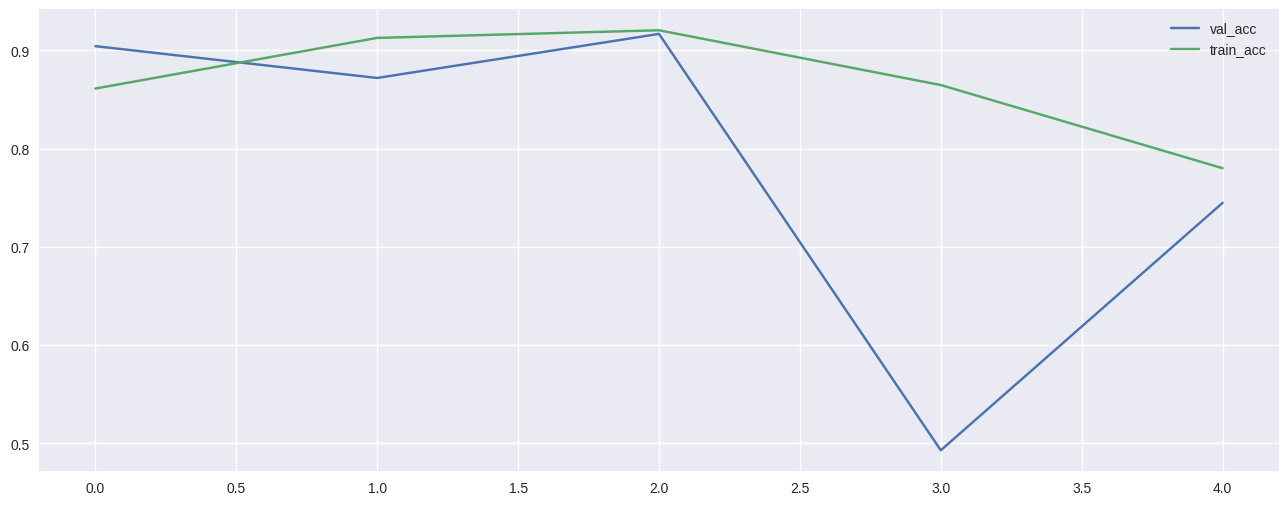

In [73]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.plot(hist.history['accuracy'], label='train_acc')
plt.legend()

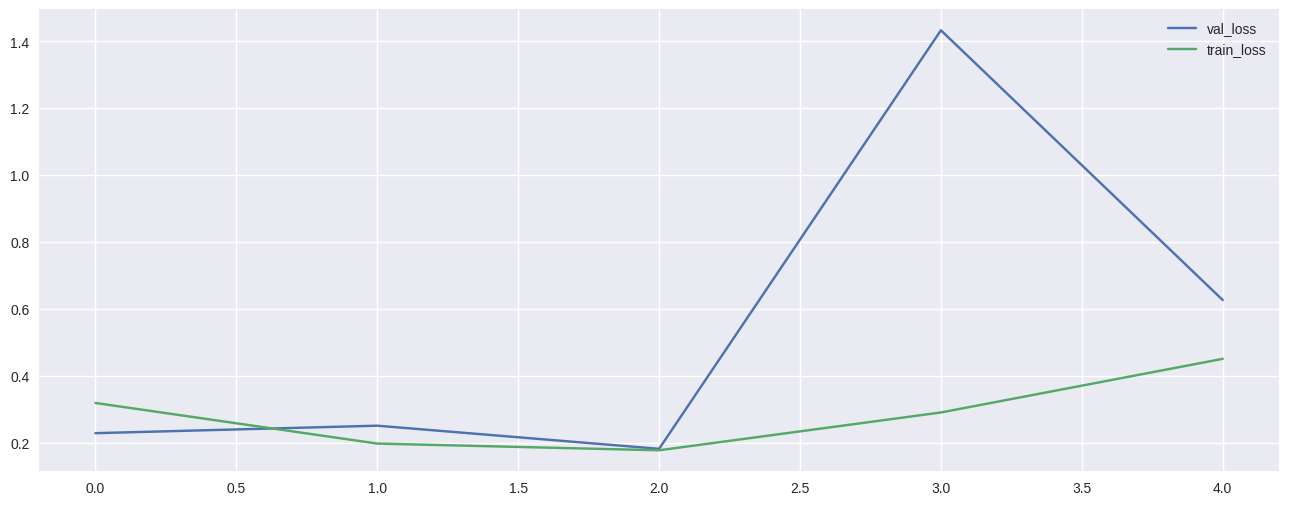

In [72]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [76]:
#accuracy_score(np.array(y_test.tolist()), test_pred.round())
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step


0.7427842358945279

In [77]:
#report = classification_report(np.array(y_test.tolist()), test_pred.round())
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     17258
           1       1.00      0.50      0.66     18012

    accuracy                           0.74     35270
   macro avg       0.83      0.75      0.73     35270
weighted avg       0.83      0.74      0.73     35270



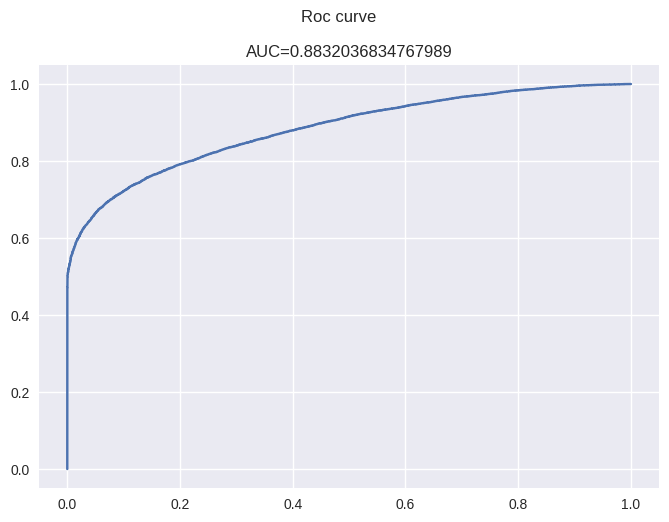

In [82]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test.tolist(), test_pred)
auc = metrics.roc_auc_score(y_test.tolist(), test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [83]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm-binary.h5'

In [ ]:
model.save(LSTM_PATH)